***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
    

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import copy

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [3]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)
    
    y_pred_train=knn.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the KNN model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=knn.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the KNN model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return knn,cm_train,cm_test,acc_train,acc_test,roc_auc

In [4]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    y_pred_train=log.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Logistic Regression model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=log.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Logistic Regression model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return log,cm_train,cm_test,acc_train,acc_test,roc_auc

In [5]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    
    y_pred_train=rf.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Random Forest Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=rf.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Random Forest Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(rf.feature_importances_,feat)
    return rf,cm_train,cm_test,acc_train,acc_test,roc_auc,rf.feature_importances_

In [6]:
def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    y_pred_train=ada.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Ada Boost Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ada.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Ada Boost Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ada.feature_importances_,feat)
    return ada,cm_train,cm_test,acc_train,acc_test,roc_auc,ada.feature_importances_

In [7]:
def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    y_pred_train=gbc.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Gradient Boosting Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=gbc.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Gradient Boosting Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(gbc.feature_importances_,feat)
    return gbc,cm_train,cm_test,acc_train,acc_test,roc_auc,gbc.feature_importances_

In [8]:
def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    y_pred_train=ext_tree.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Extra Tree Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ext_tree.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Extra Tree Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ext_tree.feature_importances_,feat)
    return ext_tree,cm_train,cm_test,acc_train,acc_test,roc_auc,ext_tree.feature_importances_

In [9]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    y_pred_train=bagging.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Bagging model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=bagging.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Bagging model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return bagging,cm_train,cm_test,acc_train,acc_test,roc_auc

In [10]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [17]:
df_html=pd.read_csv('HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
rem=['link_rel_wlwmanifest','script_src_absolute','base_count','img_src_relative','link_href_relative',
     'form_action_absolute','tbody_count','link_count',  'base_href_absolute', 'img_srcset_relative','link_rel_EditURI',
     'form_enctype_application/x-www-form-urlencoded','a_href_relative','iframe_src_absolute',
     'iframe_sandbox_allow_same_origin_count','a_href_absolute','base_href_relative','link_type_application/wlwmanifest+xml'
     ,'form_action_https','form_action_out_of_domain','nofollow_count','img_count','img_src_http','script_src_http',
     'link_href_http','a_href_http','a_href_out_of_domain','iframe_src_http']
df_html.drop(rem,axis=1,inplace=True)
print("Shape of our dataset:",df_html.shape)
df_html.head()

Shape of our dataset: (43491, 1433)


,a_charset_utf-8,a_count,a_download_download,a_hidden_true,a_href_.7z,a_href_.apk,a_href_.app,a_href_.asp,a_href_.aspx,a_href_.au,a_href_.avi,a_href_.b,a_href_.bin,a_href_.br,a_href_.bz2,a_href_.ca,a_href_.cat,a_href_.cc,a_href_.cfm,a_href_.cgi,a_href_.ch,a_href_.chn,a_href_.cl,a_href_.cms,a_href_.com,a_href_.csp,a_href_.css,a_href_.data,a_href_.de,a_href_.dmg,a_href_.do,a_href_.doc,a_href_.docx,a_href_.dot,a_href_.dz,a_href_.end,a_href_.exe,a_href_.fx,a_href_.gif,a_href_.gsp,a_href_.gz,a_href_.htm,a_href_.html,a_href_.i,a_href_.id,a_href_.io,a_href_.iso,a_href_.it,a_href_.jhtml,a_href_.jpeg,a_href_.jpg,a_href_.js,a_href_.jsf,a_href_.json,a_href_.jsp,a_href_.lnk,a_href_.m3u,a_href_.md,a_href_.me,a_href_.mhp,a_href_.mp3,a_href_.mp4,a_href_.mpl,a_href_.mvc,a_href_.net,a_href_.ogg,a_href_.org,a_href_.pcf,a_href_.pd,a_href_.pdf,a_href_.php,a_href_.phtml,a_href_.pk,a_href_.pl,a_href_.pls,a_href_.png,a_href_.prd,a_href_.pro,a_href_.rar,a_href_.rdf,a_href_.rf,a_href_.rss,a_href_.ru,a_href_.shtml,a_href_.spa,a_href_.svg,a_href_.swf,a_href_.tag,a_href_.tmpl,a_href_.tr,a_href_.tsp,a_href_.tv,a_href_.txt,a_href_.vid,a_href_.wml,a_href_.wmv,a_href_.x,a_href_.xhtml,a_href_.xls,a_href_.xlsx,a_href_.xml,a_href_.xxx,a_href_.xyz,a_href_.xz,a_href_.zip,a_href_0,a_href_0.1,a_href_0.2,a_href_ftp,a_href_https,a_href_irc,a_href_mailto,a_href_script_javascript,a_hreflang_am,a_hreflang_ar,a_hreflang_az,a_hreflang_bs,a_hreflang_ca,a_hreflang_cs,a_hreflang_de,a_hreflang_el,a_hreflang_en,a_hreflang_en-gb,a_hreflang_en-us,a_hreflang_es,a_hreflang_es-ES,a_hreflang_fi,a_hreflang_fr,a_hreflang_hu,a_hreflang_id,a_hreflang_it,a_hreflang_ja,a_hreflang_ko,a_hreflang_ml,a_hreflang_nl,a_hreflang_no,a_hreflang_pl,a_hreflang_pt,a_hreflang_pt-br,a_hreflang_ro,a_hreflang_ru,a_hreflang_sv,a_hreflang_tr,a_hreflang_und,a_hreflang_zh,a_hreflang_zh-hans,a_hreflang_zxx,a_lang_a1,a_lang_ar,a_lang_bg,a_lang_ca,a_lang_cs,a_lang_da,a_lang_de,a_lang_el,a_lang_en,a_lang_en-GB,a_lang_en-US,a_lang_es,a_lang_es-ES,a_lang_fi,a_lang_fr,a_lang_he,a_lang_hi,a_lang_hr,a_lang_hu,a_lang_id,a_lang_it,a_lang_ja,a_lang_ko,a_lang_nl,a_lang_pl,a_lang_pt,a_lang_ro,a_lang_ru,a_lang_sk,a_lang_sv,a_lang_th,a_lang_tr,a_lang_vi,a_lang_zh,a_referrerpolicy_unsafe-url,a_rel_ nofollow,a_rel_ noopener,a_rel_ noopener noreferrer,a_rel_ noreferrer noopener,"a_rel_""nofollow""",a_rel_#modal-overlay,a_rel_#modalExternalSiteCluetip,a_rel_#selectFiliale,a_rel_'nofollow',a_rel_0,a_rel_1,a_rel_10,a_rel_11,a_rel_12,a_rel_13,a_rel_14,a_rel_15,a_rel_16,a_rel_17,a_rel_2,a_rel_3,a_rel_4,a_rel_5,a_rel_6,a_rel_7,a_rel_8,a_rel_9,a_rel_<strong>@font-face Embedding</strong> - this free license allows you to embed the font in your websites with CSS.,a_rel_<strong>Commercial Desktop Use</strong> - this free license allows you to create commercial graphics and documents.,a_rel_Akamai-prefetch,a_rel_Dofollow,a_rel_F,a_rel_Lightbox,a_rel_Menu,a_rel_NOFOLLOW,a_rel__blank,a_rel_about,a_rel_accounts,a_rel_ajaxcontentarea,a_rel_alternate,a_rel_alternate noopener noreferrer,a_rel_archive,a_rel_article,a_rel_attachment,a_rel_author,a_rel_author external,a_rel_author source external,a_rel_blank,a_rel_bookmark,a_rel_bookmark noopener,a_rel_box,a_rel_canonical,a_rel_category,a_rel_category tag,a_rel_category tag noopener noreferrer,a_rel_chapter,a_rel_chartPopup nofollow,a_rel_cklog,a_rel_contact,a_rel_contents,a_rel_countrycontainer,a_rel_date,a_rel_ddsubmenuside1,a_rel_default,a_rel_designer,a_rel_detalis,a_rel_discussion,a_rel_dofollow,...,object_data_.svg,object_data_.swf,object_data_absolute,object_data_http,object_data_https,object_data_out_of_domain,object_data_relative,object_style_display: block; position: absolute; top: 0px; left: 0px; height: 100%; width: 100%; overflow: hidden; pointer-events: none; z-index: -1;,object_style_display: none;,object_type_application/x-shockwave-flash,object_type_image/svg+xml,object_type_text/html,ol_count,optgroup_count,option_count,output_count,p_count,param_count,picture_count,pre_count,pro

In [19]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'functions' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)


df_js.drop(['js_function_Object.defineProperty(',
'js_function_Object.keys(',
'js_function_.substr',
'js_function_unescape(','number_of_cookies','number_of_non_http_only_cookies'],axis=1,inplace=True)
print("Shape of our dataset:",df_js.shape)
df_js.head()

Shape of our dataset: (43294, 400)


,dom_function_document.adoptNode(,dom_function_document.captureEvents(,dom_function_document.caretPositionFromPoint(,dom_function_document.caretRangeFromPoint(,dom_function_document.clear(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createAttributeNS(,dom_function_document.createCDATASection(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEntityReference(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTouch(,dom_function_document.createTouchList(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.enableStyleSheetsForSet(,dom_function_document.execCommand(,dom_function_document.exitPointerLock(,dom_function_document.getAnimations(,dom_function_document.getElementById(,dom_function_document.getElementByName(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getElementsByTagNameNS(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.normalizeDocument(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.queryCommandIndeterm(,dom_function_document.queryCommandValue(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.releaseCapture(,dom_function_document.releaseEvent(,dom_function_document.routeEvent(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.back(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.cancelIdleCallback(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.createImageBitmap(,dom_function_window.disableExternalCapture(,dom_function_window.dispatchEvent(,dom_function_window.dump(,dom_function_window.enableExternalCapture(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.forward(,dom_function_window.getAttention(,dom_function_window.getAttentionWithCycleCount(,dom_function_window.getComputedStyle(,dom_function_window.getDefaultComputedSyle(,dom_function_window.getSelection(,dom_function_window.home(,dom_function_window.matchMedia(,dom_function_window.maximize(,dom_function_window.minimize(,dom_function_window.moveBy(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.openDialog(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.releaseEvents(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.requestIdleCallback(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.restore(,dom_function_window.routeEvent(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollByLines(,dom_function_window.scrollByPages(,dom_function_window.scrollTo(,dom_function_window.setCursor(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setResizable(,dom_function_window.setTimeout(,dom_function_window.sizeToContent(,dom_function_window.stop(,dom_function_window.updateCommands(,js_function_.add(,js_function_.all(,js_function_.allTrue(,js_function_.anchor(,js_function_.apply(,js_function_.big(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_funct

In [20]:
col_js_no_uni=remove_feat(df_js)
col_html_no_uni=remove_feat(df_html)

In [21]:
print("{} columns in JavaScript experiment with all missing or only one unique value".format(len(col_js_no_uni)))
print("{} columns in HTML experiment with all missing or only one unique value".format(len(col_html_no_uni)))

113 columns in JavaScript experiment with all missing or only one unique value
0 columns in HTML experiment with all missing or only one unique value


In [22]:
df_js.drop(col_js_no_uni,axis=1,inplace=True)
df_html.drop(col_html_no_uni,axis=1,inplace=True)

In [23]:
print("Shape of JavaScript experiemtn after dropping them:",df_js.shape)
print("Shape of HTML experiemtn after dropping them:",df_html.shape)

Shape of JavaScript experiemtn after dropping them: (43294, 287)
Shape of HTML experiemtn after dropping them: (43491, 1433)


In [24]:
col_js_95=uni_value(df_js)
col_html_95=uni_value(df_html)
print("{} columns in JavaScript experiment with more than 95% same values".format(len(col_js_95[col_js_95['95_%_same_values']==True])))
print("{} columns in HTML experiment with more than 95% same values".format(len(col_html_95[col_html_95['95_%_same_values']==True])))

234 columns in JavaScript experiment with more than 95% same values
1297 columns in HTML experiment with more than 95% same values


In [25]:
### Lets drop those columns
df_js.drop(col_js_95[col_js_95['95_%_same_values']==True].index.values,axis=1,inplace=True)

df_html.drop(col_html_95[col_html_95['95_%_same_values']==True].index.values,axis=1,inplace=True)

print("Shape of JavaScript experiment after dropping them:",df_js.shape)
print("Shape of HTML experiment after dropping them:",df_html.shape)

Shape of JavaScript experiment after dropping them: (43294, 53)
Shape of HTML experiment after dropping them: (43491, 136)


#### Let us analyze the balance of classes

In [26]:
class_bal(df_js,'JavaScript experiment')
class_bal(df_html,'HTML experiment')

#### Analyzing the categorical and numerical features

In [27]:
cat_var_js,num_var_js=check_cat(df_js)
cat_var_html,num_var_html=check_cat(df_html)

In [28]:
df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)

print("Stats for numerical features for JavaScript experiment\n")
num_stats_js=num_stats(df_js,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for JavaScript experiment\n")
cat_stats_js=cat_stats(df_js,cat_var_js)
display(cat_stats_js)

Stats for numerical features for JavaScript experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
number_of_unsecure_cookies,-0.345278,0.000000e+00,-149.577298,0.000000e+00
dom_function_document.getElementsByTagName(,-0.206833,0.000000e+00,-94.422955,0.000000e+00
number_of_http_only_cookies,-0.191954,0.000000e+00,-78.875103,0.000000e+00
dom_function_document.createElement(,-0.154604,9.233651e-230,-72.422095,0.000000e+00
js_function_.getTime(,-0.149504,8.006211e-215,-70.045384,0.000000e+00
dom_function_window.addEventListener(,-0.107093,1.299881e-110,-51.397683,0.000000e+00
number_of_secure_cookies,-0.111267,2.660489e-119,-48.907941,0.000000e+00
js_function_.split(,-0.097541,5.300145e-92,-46.252895,0.000000e+00
js_function_Math.random(,-0.094978,2.620317e-87,-44.513654,0.000000e+00



Stats for Categorical features for JavaScript experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


In [29]:
print("Stats for numerical features for HTML experiment\n")
num_stats_html=num_stats(df_html,num_var_html)
display(num_stats_html)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_html=cat_stats(df_html,cat_var_html)
display(cat_stats_html)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
script_src_.js,-0.319546,0.000000e+00,-142.596194,0.000000e+00
script_count,-0.315619,0.000000e+00,-142.448699,0.000000e+00
script_src_relative,-0.310931,0.000000e+00,-135.577261,0.000000e+00
script_src_https,-0.271077,0.000000e+00,-126.553948,0.000000e+00
script_async_true,-0.245742,0.000000e+00,-118.214320,0.000000e+00
link_rel_canonical,-0.276351,0.000000e+00,-114.117813,0.000000e+00
div_count,-0.231558,0.000000e+00,-113.026088,0.000000e+00
script_type_text/javascript,-0.264055,0.000000e+00,-111.582561,0.000000e+00
script_src_out_of_domain,-0.246691,0.000000e+00,-106.660880,0.000000e+00



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


In [30]:
fin_col=num_stats_js.index.values[0:25].tolist()+cat_stats_js.index.values[0:25].tolist() + num_stats_html.index.values[0:25].tolist()+cat_stats_html.index.values[0:25].tolist() 

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [31]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [32]:
print("Features we will be using:")
display(fin_col)

Features we will be using:


['number_of_unsecure_cookies',
 'dom_function_document.getElementsByTagName(',
 'number_of_http_only_cookies',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'number_of_secure_cookies',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_Math.round(',
 'js_function_.substring(',
 'js_function_.shift(',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'meta_http-equiv_X-UA-Compatible',
 'l

In [33]:
df_int=pd.merge(df_js,df_html,left_index=True,right_index=True)

df=df_int.copy(deep=True)

df['Target']=df[['Target_x','Target_y']].apply(max,axis=1)

In [34]:
columns=copy.deepcopy(fin_col)
fin_col.append('Target')

df_sel=df[fin_col]

display(df_sel.shape)

(40709, 51)

In [35]:
class_bal(df_sel,'Combined experiments')

In [36]:
### Preparing our training and test sets
X=df_sel.iloc[:,df_sel.columns!='Target'].values
y=df_sel.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [37]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [38]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [39]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.902385850708
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25156  2706    27862
True         473  4232     4705
__all__    25629  6938    32567

Accuracy of the KNN model for twst data is: 0.900147383935
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6241   675     6916
True         138  1088     1226
__all__     6379  1763     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.883839469402
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25004  2858    27862
True         925  3780     4705
__all__    25929  6638    32567

Accuracy of the Logistic Regression model for twst data is: 0.882706951609
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6198   718     6916
True         237   989     1226
__all__     6435  1707     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.914545398716
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25253  2609    27862
True         174  4531     4705
__all__    25427  7140    32567

Accuracy of the Random Forest Classifier for twst data is: 0.903217882584
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6261   655     6916
True         133  1093     1226
__all__     6394  1748     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.890042067123
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25037  2825    27862
True         756  3949     4705
__all__    25793  6774    32567

Accuracy of the Ada Boost Classifier for twst data is: 0.890444608204
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6222   694     6916
True         198  1028     1226
__all__     6420  1722     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.899499493352
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25220  2642    27862
True         631  4074     4705
__all__    25851  6716    32567

Accuracy of the Gradient Boosting Classifier for twst data is: 0.897690985016
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6263   653     6916
True         180  1046     1226
__all__     6443  1699     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.916510578193
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25255  2607    27862
True         112  4593     4705
__all__    25367  7200    32567

Accuracy of the Extra Tree Classifier for twst data is: 0.903709162368
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6259   657     6916
True         127  1099     1226
__all__     6386  1756     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.914269045353
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25260  2602    27862
True         190  4515     4705
__all__    25450  7117    32567

Accuracy of the Bagging model for twst data is: 0.902849422746
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6257   659     6916
True         132  1094     1226
__all__     6389  1753     8142



Neural Network-1
The accuracy of the model on training data is: 0.90518009029


Predicted  False  True  __all__
Actual                         
False      25036  2826    27862
True         262  4443     4705
__all__    25298  7269    32567

The accuracy of the model on test data is: 0.892532547286


Predicted  False  True  __all__
Actual                         
False       6185   731     6916
True         144  1082     1226
__all__     6329  1813     8142

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [40]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [41]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.902386,4232.0,25156.0,2706.0,473.0,0.097122,0.100531
LogisticRegression,0.883839,3780.0,25004.0,2858.0,925.0,0.102577,0.196599
RandomForestClassifier,0.914545,4531.0,25253.0,2609.0,174.0,0.093640,0.036982
AdaBoostClassifier,0.890042,3949.0,25037.0,2825.0,756.0,0.101393,0.160680
GradientBoostingClassifier,0.899499,4074.0,25220.0,2642.0,631.0,0.094824,0.134113
ExtraTreeClassifier,0.916511,4593.0,25255.0,2607.0,112.0,0.093568,0.023804
BaggingClassifier,0.914269,4515.0,25260.0,2602.0,190.0,0.093389,0.040383
Neural Network-1,0.905180,4443.0,25036.0,2826.0,262.0,0.101428,0.055685


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.900147,1088.0,6241.0,675.0,138.0,0.097600,0.112561,0.894920
LogisticRegression,0.882707,989.0,6198.0,718.0,237.0,0.103817,0.193312,0.851436
RandomForestClassifier,0.903218,1093.0,6261.0,655.0,133.0,0.094708,0.108483,0.898405
AdaBoostClassifier,0.890445,1028.0,6222.0,694.0,198.0,0.100347,0.161501,0.869076
GradientBoostingClassifier,0.897691,1046.0,6263.0,653.0,180.0,0.094419,0.146819,0.879381
ExtraTreeClassifier,0.903709,1099.0,6259.0,657.0,127.0,0.094997,0.103589,0.900707
BaggingClassifier,0.902849,1094.0,6257.0,659.0,132.0,0.095286,0.107667,0.898523
Neural Network-1,0.892533,1082.0,6185.0,731.0,144.0,0.105697,0.117455,0.898523


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [42]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [43]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [44]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

Entityset: malicious
  Entities:
    data [Rows: 40709, Columns: 51]
  Relationships:
    No relationships

In [45]:
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 4950 features
EntitySet scattered to workers in 5.666 seconds
Elapsed: 00:34 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [46]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [47]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [48]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [49]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [50]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [51]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [52]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [54]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(40709, 27)

In [55]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['number_of_secure_cookies + number_of_unsecure_cookies',
 'number_of_http_only_cookies + number_of_unsecure_cookies',
 'dom_function_document.getElementsByTagName( + number_of_unsecure_cookies',
 'script_src_out_of_domain / script_src_relative',
 'script_src_https / script_src_relative',
 'script_async_true / script_count',
 'number_of_unsecure_cookies + script_src_out_of_domain',
 'number_of_unsecure_cookies',
 'meta_http-equiv_X-UA-Compatible + number_of_unsecure_cookies',
 'link_rel_stylesheet + number_of_unsecure_cookies',
 'link_rel_shortcut icon + number_of_unsecure_cookies',
 'link_rel_icon + number_of_unsecure_cookies',
 'link_rel_canonical + number_of_unsecure_cookies',
 'link_rel_canonical + meta_http-equiv_X-UA-Compatible',
 'link_href_.ico + number_of_unsecure_cookies',
 'js_function_Math.round( + number_of_unsecure_cookies',
 'js_function_Math.random( + number_of_unsecure_cookies',
 'js_function_Math.floor( + number_of_unsecure_cookies',
 'js_function_JSON.parse( + number

In [56]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [57]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.895661252188
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24868  2937    27805
True         461  4301     4762
__all__    25329  7238    32567

Accuracy of the KNN model for twst data is: 0.888847948907
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6208   765     6973
True         140  1029     1169
__all__     6348  1794     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.880646052753
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24857  2948    27805
True         939  3823     4762
__all__    25796  6771    32567

Accuracy of the Logistic Regression model for twst data is: 0.879513633014
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6212   761     6973
True         220   949     1169
__all__     6432  1710     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.907544446833
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25047  2758    27805
True         253  4509     4762
__all__    25300  7267    32567

Accuracy of the Random Forest Classifier for twst data is: 0.894006386637
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6244   729     6973
True         134  1035     1169
__all__     6378  1764     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.88568182516
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24887  2918    27805
True         805  3957     4762
__all__    25692  6875    32567

Accuracy of the Ada Boost Classifier for twst data is: 0.883566691231
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6214   759     6973
True         189   980     1169
__all__     6403  1739     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.894924309884
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25068  2737    27805
True         685  4077     4762
__all__    25753  6814    32567

Accuracy of the Gradient Boosting Classifier for twst data is: 0.890321788258
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6252   721     6973
True         172   997     1169
__all__     6424  1718     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.909571038167
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25057  2748    27805
True         197  4565     4762
__all__    25254  7313    32567

Accuracy of the Extra Tree Classifier for twst data is: 0.894866126259
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6243   730     6973
True         126  1043     1169
__all__     6369  1773     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.907605858691
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25046  2759    27805
True         250  4512     4762
__all__    25296  7271    32567

Accuracy of the Bagging model for twst data is: 0.894129206583
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6238   735     6973
True         127  1042     1169
__all__     6365  1777     8142



Neural Network-1
The accuracy of the model on training data is: 0.890594773845


Predicted  False  True  __all__
Actual                         
False      24886  2919    27805
True         644  4118     4762
__all__    25530  7037    32567

The accuracy of the model on test data is: 0.885900270204


Predicted  False  True  __all__
Actual                         
False       6211   762     6973
True         167  1002     1169
__all__     6378  1764     8142

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [58]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [59]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.895661,4301.0,24868.0,2937.0,461.0,0.105628,0.096808
LogisticRegression,0.880646,3823.0,24857.0,2948.0,939.0,0.106024,0.197186
RandomForestClassifier,0.907544,4509.0,25047.0,2758.0,253.0,0.099191,0.053129
AdaBoostClassifier,0.885682,3957.0,24887.0,2918.0,805.0,0.104945,0.169047
GradientBoostingClassifier,0.894924,4077.0,25068.0,2737.0,685.0,0.098436,0.143847
ExtraTreeClassifier,0.909571,4565.0,25057.0,2748.0,197.0,0.098831,0.041369
BaggingClassifier,0.907606,4512.0,25046.0,2759.0,250.0,0.099227,0.052499
Neural Network-1,0.890595,4118.0,24886.0,2919.0,644.0,0.104981,0.135237


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.888848,1029.0,6208.0,765.0,140.0,0.109709,0.119760,0.885265
LogisticRegression,0.879514,949.0,6212.0,761.0,220.0,0.109135,0.188195,0.851335
RandomForestClassifier,0.894006,1035.0,6244.0,729.0,134.0,0.104546,0.114628,0.890413
AdaBoostClassifier,0.883567,980.0,6214.0,759.0,189.0,0.108848,0.161677,0.864737
GradientBoostingClassifier,0.890322,997.0,6252.0,721.0,172.0,0.103399,0.147134,0.874733
ExtraTreeClassifier,0.894866,1043.0,6243.0,730.0,126.0,0.104690,0.107784,0.893763
BaggingClassifier,0.894129,1042.0,6238.0,735.0,127.0,0.105407,0.108640,0.892977
Neural Network-1,0.885900,1002.0,6211.0,762.0,167.0,0.109279,0.142857,0.892977


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [60]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [61]:
X=fs.loc[:,df.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

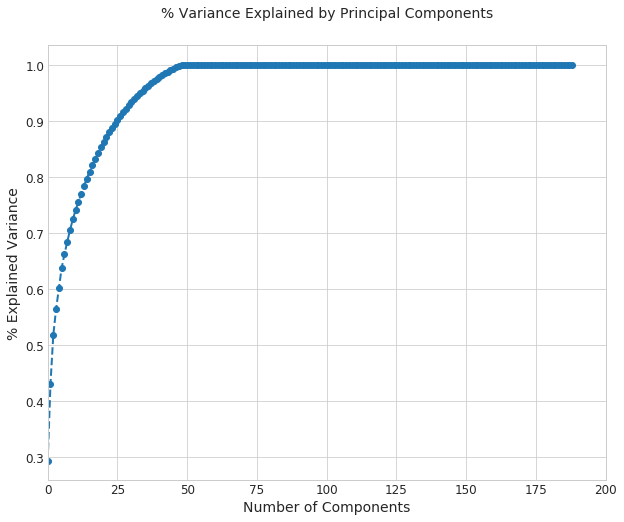

In [62]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [63]:
n=np.where(np.cumsum(pca.explained_variance_ratio_)>=0.99)[0][0]

In [64]:
pca=PCA(n_components=n,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using {} components is {}".format(n,sum(pca.explained_variance_ratio_)))

Variance explained using 44 components is 0.9883735542634652


In [65]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [66]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [67]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,n).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.902600792213
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25092  2713    27805
True         459  4303     4762
__all__    25551  7016    32567

Accuracy of the KNN model for twst data is: 0.89633996561
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6261   712     6973
True         132  1037     1169
__all__     6393  1749     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.883808763472
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24959  2846    27805
True         938  3824     4762
__all__    25897  6670    32567

Accuracy of the Logistic Regression model for twst data is: 0.882338491771
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6239   734     6973
True         224   945     1169
__all__     6463  1679     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.914637516504
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25200  2605    27805
True         175  4587     4762
__all__    25375  7192    32567

Accuracy of the Random Forest Classifier for twst data is: 0.900147383935
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6294   679     6973
True         134  1035     1169
__all__     6428  1714     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.890656185709
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25045  2760    27805
True         801  3961     4762
__all__    25846  6721    32567

Accuracy of the Ada Boost Classifier for twst data is: 0.888111029231
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6256   717     6973
True         194   975     1169
__all__     6450  1692     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.901311143182
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25240  2565    27805
True         649  4113     4762
__all__    25889  6678    32567

Accuracy of the Gradient Boosting Classifier for twst data is: 0.89633996561
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6308   665     6973
True         179   990     1169
__all__     6487  1655     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.916848343415
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25218  2587    27805
True         121  4641     4762
__all__    25339  7228    32567

Accuracy of the Extra Tree Classifier for twst data is: 0.901252763449
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6299   674     6973
True         130  1039     1169
__all__     6429  1713     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.914453280929
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25201  2604    27805
True         182  4580     4762
__all__    25383  7184    32567

Accuracy of the Bagging model for twst data is: 0.899533284205
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6286   687     6973
True         131  1038     1169
__all__     6417  1725     8142



Neural Network-1
The accuracy of the model on training data is: 0.907329505322


Predicted  False  True  __all__
Actual                         
False      25019  2786    27805
True         232  4530     4762
__all__    25251  7316    32567

The accuracy of the model on test data is: 0.892655367232


Predicted  False  True  __all__
Actual                         
False       6221   752     6973
True         122  1047     1169
__all__     6343  1799     8142

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [68]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [69]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.902601,4303.0,25092.0,2713.0,459.0,0.097572,0.096388
LogisticRegression,0.883809,3824.0,24959.0,2846.0,938.0,0.102356,0.196976
RandomForestClassifier,0.914638,4587.0,25200.0,2605.0,175.0,0.093688,0.036749
AdaBoostClassifier,0.890656,3961.0,25045.0,2760.0,801.0,0.099263,0.168207
GradientBoostingClassifier,0.901311,4113.0,25240.0,2565.0,649.0,0.092250,0.136287
ExtraTreeClassifier,0.916848,4641.0,25218.0,2587.0,121.0,0.093041,0.025409
BaggingClassifier,0.914453,4580.0,25201.0,2604.0,182.0,0.093652,0.038219
Neural Network-1,0.907330,4530.0,25019.0,2786.0,232.0,0.100198,0.048719


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.896340,1037.0,6261.0,712.0,132.0,0.102108,0.112917,0.892487
LogisticRegression,0.882338,945.0,6239.0,734.0,224.0,0.105263,0.191617,0.851560
RandomForestClassifier,0.900147,1035.0,6294.0,679.0,134.0,0.097376,0.114628,0.893998
AdaBoostClassifier,0.888111,975.0,6256.0,717.0,194.0,0.102825,0.165954,0.865611
GradientBoostingClassifier,0.896340,990.0,6308.0,665.0,179.0,0.095368,0.153122,0.875755
ExtraTreeClassifier,0.901253,1039.0,6299.0,674.0,130.0,0.096659,0.111206,0.896068
BaggingClassifier,0.899533,1038.0,6286.0,687.0,131.0,0.098523,0.112062,0.894708
Neural Network-1,0.892655,1047.0,6221.0,752.0,122.0,0.107845,0.104363,0.894708


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [70]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,n).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [71]:
# fin_col.remove('Target')
# columns=fin_col
print("Features we will be using:")
display(columns)

Features we will be using:


['number_of_unsecure_cookies',
 'dom_function_document.getElementsByTagName(',
 'number_of_http_only_cookies',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'number_of_secure_cookies',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_Math.round(',
 'js_function_.substring(',
 'js_function_.shift(',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'meta_http-equiv_X-UA-Compatible',
 'l

In [72]:
### Preparing our training and test sets
columns.remove('domain')
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [74]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [75]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.928720120594
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24485   3377    27862
True         595  27267    27862
__all__    25080  30644    55724

Accuracy of the KNN model for twst data is: 0.877302873987
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6005   911     6916
True          88  1138     1226
__all__     6093  2049     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.883945876104
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22780   5082    27862
True        1385  26477    27862
__all__    24165  31559    55724

Accuracy of the Logistic Regression model for twst data is: 0.841316629821
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5685  1231     6916
True          61  1165     1226
__all__     5746  2396     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.947365587539
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25066   2796    27862
True         137  27725    27862
__all__    25203  30521    55724

Accuracy of the Random Forest Classifier for twst data is: 0.901129943503
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6206   710     6916
True          95  1131     1226
__all__     6301  1841     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.900994185629
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23688   4174    27862
True        1343  26519    27862
__all__    25031  30693    55724

Accuracy of the Ada Boost Classifier for twst data is: 0.868214197986
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5910  1006     6916
True          67  1159     1226
__all__     5977  2165     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.923085205656
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24282   3580    27862
True         706  27156    27862
__all__    24988  30736    55724

Accuracy of the Gradient Boosting Classifier for twst data is: 0.88086465242
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6029   887     6916
True          83  1143     1226
__all__     6112  2030     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.948191084631
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25073   2789    27862
True          98  27764    27862
__all__    25171  30553    55724

Accuracy of the Extra Tree Classifier for twst data is: 0.901129943503
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6213   703     6916
True         102  1124     1226
__all__     6315  1827     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.947311750772
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25066   2796    27862
True         140  27722    27862
__all__    25206  30518    55724

Accuracy of the Bagging model for twst data is: 0.898427904692
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6179   737     6916
True          90  1136     1226
__all__     6269  1873     8142



Neural Network-1
The accuracy of the model on training data is: 0.937854425382


Predicted  False   True  __all__
Actual                          
False      24580   3282    27862
True         181  27681    27862
__all__    24761  30963    55724

The accuracy of the model on test data is: 0.886882829772


Predicted  False  True  __all__
Actual                         
False       6064   852     6916
True          69  1157     1226
__all__     6133  2009     8142

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [76]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [77]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.928720,27267.0,24485.0,3377.0,595.0,0.121205,0.021355
LogisticRegression,0.883946,26477.0,22780.0,5082.0,1385.0,0.182399,0.049709
RandomForestClassifier,0.947366,27725.0,25066.0,2796.0,137.0,0.100352,0.004917
AdaBoostClassifier,0.900994,26519.0,23688.0,4174.0,1343.0,0.149810,0.048202
GradientBoostingClassifier,0.923085,27156.0,24282.0,3580.0,706.0,0.128490,0.025339
ExtraTreeClassifier,0.948191,27764.0,25073.0,2789.0,98.0,0.100100,0.003517
BaggingClassifier,0.947312,27722.0,25066.0,2796.0,140.0,0.100352,0.005025
Neural Network-1,0.937854,27681.0,24580.0,3282.0,181.0,0.117795,0.006496


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.877303,1138.0,6005.0,911.0,88.0,0.131724,0.071778,0.898249
LogisticRegression,0.841317,1165.0,5685.0,1231.0,61.0,0.177993,0.049755,0.886126
RandomForestClassifier,0.901130,1131.0,6206.0,710.0,95.0,0.102660,0.077488,0.909926
AdaBoostClassifier,0.868214,1159.0,5910.0,1006.0,67.0,0.145460,0.054649,0.899945
GradientBoostingClassifier,0.880865,1143.0,6029.0,887.0,83.0,0.128253,0.067700,0.902023
ExtraTreeClassifier,0.901130,1124.0,6213.0,703.0,102.0,0.101648,0.083197,0.907577
BaggingClassifier,0.898428,1136.0,6179.0,737.0,90.0,0.106564,0.073409,0.910013
Neural Network-1,0.886883,1157.0,6064.0,852.0,69.0,0.123193,0.056281,0.910013


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [78]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [79]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (11862, 190)


,dom_function_document.createElement(,dom_function_document.getElementById(,dom_function_document.getElementsByTagName(,dom_function_document.querySelector(,dom_function_document.write(,dom_function_window.addEventListener(,dom_function_window.open(,dom_function_window.setTimeout(,js_function_.add(,js_function_.apply(,js_function_.bind(,js_function_.call(,js_function_.charAt(,js_function_.concat(,js_function_.defineProperty(,js_function_.exec(,js_function_.find(,js_function_.forEach(,js_function_.get(,js_function_.getTime(,js_function_.hasOwnProperty(,js_function_.indexOf(,js_function_.join(,js_function_.keys(,js_function_.log(,js_function_.match(,js_function_.pop(,js_function_.push(,js_function_.replace(,js_function_.setTime(,js_function_.shift(,js_function_.slice(,js_function_.split(,js_function_.substring(,js_function_.test(,js_function_.toLowerCase(,js_function_.toString(,js_function_.trim(,js_function_JSON.parse(,js_function_JSON.stringify(,js_function_Math.floor(,js_function_Math.max(,js_function_Math.random(,js_function_Math.round(,js_function_decodeURIComponent(,js_function_encodeURIComponent(,js_function_escape(,js_function_isNaN(,js_function_parseInt(,number_of_http_only_cookies,number_of_secure_cookies,number_of_unsecure_cookies,Target_x,a_count,a_href_.aspx,a_href_.com,a_href_.htm,a_href_.html,a_href_.pdf,a_href_.php,a_href_0,a_href_https,a_href_mailto,a_href_script_javascript,a_rel_nofollow,article_count,aside_count,b_count,base_href_out_of_domain,br_count,button_count,center_count,dd_count,div_count,dl_count,dt_count,em_count,fieldset_count,figure_count,font_count,footer_count,form_action_.php,form_action_http,form_action_relative,form_count,h1_count,header_count,hr_count,i_count,iframe_count,iframe_sandbox_allow_scripts_count,iframe_src_.com,iframe_src_.html,iframe_src_0,iframe_src_https,iframe_src_out_of_domain,iframe_src_relative,img_src_.gif,img_src_.jpeg,img_src_.jpg,img_src_.png,img_src_.svg,img_src_0,img_src_absolute,img_src_https,img_src_out_of_domain,img_srcset_absolute,img_srcset_https,img_srcset_out_of_domain,input_count,ins_count,label_count,li_count,link_href_.com,link_href_.css,link_href_.ico,link_href_.json,link_href_.php,link_href_.png,link_href_.xml,link_href_0,link_href_absolute,link_href_https,link_href_out_of_domain,link_rel_alternate,link_rel_apple-touch-icon,link_rel_apple-touch-icon-precomposed,link_rel_canonical,link_rel_dns-prefetch,link_rel_https://api.w.org/,link_rel_icon,link_rel_manifest,link_rel_next,link_rel_pingback,link_rel_preload,link_rel_profile,link_rel_publisher,link_rel_shortcut icon,link_rel_shortlink,link_rel_stylesheet,link_type_application/rsd+xml,link_type_application/rss+xml,link_type_image/png,link_type_image/x-icon,link_type_text/css,main_count,meta_charset_UTF-8,meta_charset_utf-8,meta_count,meta_http-equiv_Content-Type,meta_http-equiv_X-UA-Compatible,meta_http-equiv_content-type,nav_count,noopener_count,noscript_count,ol_count,option_count,p_count,script_async_true,script_charset_UTF-8,script_charset_utf-8,script_count,script_crossorigin_anonymous,script_defer_true,script_language_JavaScript,script_language_javascript,script_src_.com,script_src_.js,script_src_0,script_src_https,script_src_out_of_domain,script_src_relative,script_type_application/ld+json,script_type_text/javascript,section_count,select_count,small_count,source_count,span_count,strong_count,style_count,table_count,td_count,textarea_count,time_count,title_count,tr_count,ul_count,Target_y,Target
domain,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
vpnmentor.com,2.0,0.0,5.0,0.0,0.0,1.0,4.0,3.0,0.0,3.0,6.0,9.0,0.0,3.0,1.0,0.0,0.0,0.0,4.0,4.0,1.0,26.0,12.0,0.0,0.0,0.0,1.0,10.0,0.0,0.0,2.0,0.0,14.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,8.0,4.0,1.0,0.0,1.0,1.0,0.0,8.0,0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,177.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,197.0,0

In [80]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [81]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [82]:
print('Features we will be using:\n')
display(columns)

Features we will be using:



['number_of_unsecure_cookies',
 'dom_function_document.getElementsByTagName(',
 'number_of_http_only_cookies',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'number_of_secure_cookies',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_Math.round(',
 'js_function_.substring(',
 'js_function_.shift(',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'meta_http-equiv_X-UA-Compatible',
 'l

In [83]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.912741068606
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4160   612     4772
True         216  4501     4717
__all__     4376  5113     9489

Accuracy of the KNN model for twst data is: 0.888748419722
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        975   184     1159
True          80  1134     1214
__all__     1055  1318     2373



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.883022447044
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3900   872     4772
True         238  4479     4717
__all__     4138  5351     9489

Accuracy of the Logistic Regression model for twst data is: 0.868520859671
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        923   236     1159
True          76  1138     1214
__all__      999  1374     2373



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.946358941933
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4305   467     4772
True          42  4675     4717
__all__     4347  5142     9489

Accuracy of the Random Forest Classifier for twst data is: 0.898019384745
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        993   166     1159
True          76  1138     1214
__all__     1069  1304     2373



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.895984824534
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4083   689     4772
True         298  4419     4717
__all__     4381  5108     9489

Accuracy of the Ada Boost Classifier for twst data is: 0.87189211968
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        956   203     1159
True         101  1113     1214
__all__     1057  1316     2373



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.915270312994
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4164   608     4772
True         196  4521     4717
__all__     4360  5129     9489

Accuracy of the Gradient Boosting Classifier for twst data is: 0.890855457227
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        966   193     1159
True          66  1148     1214
__all__     1032  1341     2373



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.949625882601
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4314   458     4772
True          20  4697     4717
__all__     4334  5155     9489

Accuracy of the Extra Tree Classifier for twst data is: 0.895490939739
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1002   157     1159
True          91  1123     1214
__all__     1093  1280     2373



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.945937401201
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4311   461     4772
True          52  4665     4717
__all__     4363  5126     9489

Accuracy of the Bagging model for twst data is: 0.904340497261
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        995   164     1159
True          63  1151     1214
__all__     1058  1315     2373



Neural Network-1
The accuracy of the model on training data is: 0.93740120141


Predicted  False  True  __all__
Actual                         
False       4203   569     4772
True          25  4692     4717
__all__     4228  5261     9489

The accuracy of the model on test data is: 0.890012642225


Predicted  False  True  __all__
Actual                         
False        953   206     1159
True          55  1159     1214
__all__     1008  1365     2373

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [84]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [85]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.912741,4501.0,4160.0,612.0,216.0,0.128248,0.045792
LogisticRegression,0.883022,4479.0,3900.0,872.0,238.0,0.182733,0.050456
RandomForestClassifier,0.946359,4675.0,4305.0,467.0,42.0,0.097863,0.008904
AdaBoostClassifier,0.895985,4419.0,4083.0,689.0,298.0,0.144384,0.063176
GradientBoostingClassifier,0.915270,4521.0,4164.0,608.0,196.0,0.127410,0.041552
ExtraTreeClassifier,0.949626,4697.0,4314.0,458.0,20.0,0.095977,0.004240
BaggingClassifier,0.945937,4665.0,4311.0,461.0,52.0,0.096605,0.011024
Neural Network-1,0.937401,4692.0,4203.0,569.0,25.0,0.119237,0.005300


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.888748,1134.0,975.0,184.0,80.0,0.158758,0.065898,0.887672
LogisticRegression,0.868521,1138.0,923.0,236.0,76.0,0.203624,0.062603,0.866887
RandomForestClassifier,0.898019,1138.0,993.0,166.0,76.0,0.143227,0.062603,0.897085
AdaBoostClassifier,0.871892,1113.0,956.0,203.0,101.0,0.175151,0.083196,0.870826
GradientBoostingClassifier,0.890855,1148.0,966.0,193.0,66.0,0.166523,0.054366,0.889556
ExtraTreeClassifier,0.895491,1123.0,1002.0,157.0,91.0,0.135462,0.074959,0.894790
BaggingClassifier,0.904340,1151.0,995.0,164.0,63.0,0.141501,0.051895,0.903302
Neural Network-1,0.890013,1159.0,953.0,206.0,55.0,0.177739,0.045305,0.903302


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [86]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [87]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')